# Pre-process LIDC CT scans to extract labelled nodules

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [16]:
from tqdm import tqdm

In [2]:
import os
import numpy as np
import pandas as pd

# import pylidc as pl

import feather # for writing data frame to disk (works with R)
import png
from utils import *

ModuleNotFoundError: No module named 'pylidc'

The LIDC database contains annotations of up to 4 radiologist per nodule.
We need to combine these annotations. Luckily, the pylidc module provides a way to cluster annotations from overlapping nodules


It turns out that 'nodule_id' does not refer to a nodule at all, they do not overlap.
Luckily, pylidc has functionality built in to determine which nodules belong together

Extract annotations to dataframe (note: using pd.read_sql_table might be better but I couldn't figure out which connection to use)

## Load scans with pylidc
We include as subset of the scans for testing purposes

In [3]:
scans = pl.query(pl.Scan).all()
scans3 = scans[0:2]

We can see that scans can contain multiple annotations

In [4]:
scans[0].annotations

[Annotation(id=1,scan_id=1),
 Annotation(id=2,scan_id=1),
 Annotation(id=3,scan_id=1),
 Annotation(id=4,scan_id=1),
 Annotation(id=5,scan_id=1),
 Annotation(id=6,scan_id=1),
 Annotation(id=7,scan_id=1),
 Annotation(id=8,scan_id=1),
 Annotation(id=9,scan_id=1),
 Annotation(id=10,scan_id=1),
 Annotation(id=11,scan_id=1),
 Annotation(id=12,scan_id=1),
 Annotation(id=13,scan_id=1)]

We want to combine the annotations for each nodule to be able to assign a single label (malignant vs benign) to each nodule

In [5]:
annotation_df3 = flatten_annotations_by_nodule(scans3)

/nfs/rtsan02/userdata/home/wamsterd/github/lidc-binary-classification/utils.py:71: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  df = pd.concat([df, nodule_df], axis = 0)


In [6]:
annotation_df3

,annotation_id,calcification,internalstructure,lobulation,malignancy,margin,nodule_id,nodule_number,patient_id,scan_id,sphericity,spiculation,sublety,texture
0,2,6,1,1,3,4,4,1.0,LIDC-IDRI-0078,1,4,2,4,5
1,6,6,1,2,4,2,12329,1.0,LIDC-IDRI-0078,1,4,1,4,5
2,10,6,1,4,5,4,16317,1.0,LIDC-IDRI-0078,1,4,4,5,5
3,13,6,1,2,3,3,2054,1.0,LIDC-IDRI-0078,1,4,2,5,4
0,1,6,1,1,3,4,3,2.0,LIDC-IDRI-0078,1,3,1,5,5
1,5,6,1,3,4,2,12325,2.0,LIDC-IDRI-0078,1,4,1,4,4
2,9,6,1,4,5,2,16313,2.0,LIDC-IDRI-0078,1,5,3,5,5
3,12,6,1,4,3,3,2050,2.0,LIDC-IDRI-0078,1,4,4,5,4
0,8,5,1,1,1,5,16332,3.0,LIDC-IDRI-0078,1,5,1,4,5
0,3,4,1,2,4,5,6,4.0,LIDC-IDRI-0078,1,3,3,5,5


As we see, each annooation has an id, there are nodule ids, but these don't coincide accross annotations, while in reality, some annotations concern the same actual nodule. This data is combined in the 'nodule_number' column, which numbers the nodules for each patient

In [7]:
annotation_df = flatten_annotations_by_nodule(scans)

/nfs/rtsan02/userdata/home/wamsterd/github/lidc-binary-classification/utils.py:71: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  df = pd.concat([df, nodule_df], axis = 0)


Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.
Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.
Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.
Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.
Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.
Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.
Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.
Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.
Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.
Failed to reduce all groups to <= 4 Annotations.
Some n

Add the patient number as a column to de DataFrame, and create an actual nodule ID based on the patient number and the nodule number

In [8]:
annotation_df = annotation_df.assign(patient_number = annotation_df["patient_id"].str[-4:])
annotation_df = annotation_df.assign(nodule_idx = annotation_df[['patient_number', 'nodule_number']].apply(lambda x: str(x[0])+str("%02d" % x[1]), axis = 1))
feather.write_dataframe(annotation_df, os.path.join("resources", "annotation_df.feather"))
annotation_df.to_csv(os.path.join("resources", "annotation_df.csv"))

Takes a long time, so this is stored and can be picked up here:

In [121]:
annotation_df = feather.read_dataframe(os.path.join("resources", "annotation_df.feather"))

Each reader gives an the rating of the nodule malignancy from 1 to 5, with 1 being benign, 5 being malignant.

Please not that this is 'only' the radiologist visual assessment of malignancy. The actual ground truth label of malignancy should be based on a biopsy (or > 2 years follow-up scans without significant growth)

However, we will use the radiologists interpretation as actual labels, since that's all we have for all nodules (however there exists a subset for which the actual diagnoses are known, see Patient Diagnosis at https://wiki.cancerimagingarchive.net/display/Public/LIDC-IDRI)

Group the DataFrame by nodule and get summary

Define a value of 3 to be borderline (not clearly malignant or benign)

In [122]:
annotation_df = annotation_df.assign(malignancy = (annotation_df.malignancy - 3) / 2)

In [220]:
nodule_df = annotation_df.groupby(["nodule_idx", "nodule_number",
                      "patient_id", "scan_id", "patient_number"], as_index = False).agg(
    {'malignancy': ['median', 'mean', 'min', 'max'], "annotation_id": 'count'}).rename(columns = {'annotation_id':'n_annotations'})
nodule_df = flatten_multiindex_columns(nodule_df)
nodule_df = nodule_df.assign(
    borderline = (np.sign(nodule_df.malignancy_min) == -np.sign(nodule_df.malignancy_max)) | (
                np.abs(nodule_df.malignancy_mean) <= 0.5 / 4),
    malignant = nodule_df.malignancy_mean > 0)
    
# nodule_df = nodule_df.assign(borderline = (nodule_df.malignancy > 2) & (nodule_df.malignancy < 4))
# nodule_df = nodule_df.assign(malignant = nodule_df.malignancy > 3)
print(nodule_df.head())
print(nodule_df.shape)
# plt.hist(np.abs(nodule_df.malignancy_mean[nodule_df.borderline == False]))
print(nodule_df.pivot_table(values = "nodule_idx", index = "borderline", columns = "malignant", aggfunc='count', fill_value = 0))

feather.write_dataframe(nodule_df, os.path.join("resources", "nodule_df.feather"))
nodule_df.to_csv(os.path.join("resources", "nodule_df.csv"))

  nodule_idx  nodule_number      patient_id scan_id patient_number  \
0     000101            1.0  LIDC-IDRI-0001      12           0001   
1     000201            1.0  LIDC-IDRI-0002      13           0002   
2     000301            1.0  LIDC-IDRI-0003      14           0003   
3     000302            2.0  LIDC-IDRI-0003      14           0003   
4     000303            3.0  LIDC-IDRI-0003      14           0003   

   malignancy_median  malignancy_mean  malignancy_min  malignancy_max  \
0               1.00            0.875             0.5             1.0   
1               0.75            0.750             0.5             1.0   
2              -0.50           -0.500            -0.5            -0.5   
3               0.75            0.625             0.0             1.0   
4               0.25            0.125            -0.5             0.5   

   n_annotations_count  borderline  malignant  
0                    4       False       True  
1                    2       False       Tru

In [10]:
nodule_df.head()

,nodule_idx,nodule_number,patient_id,scan_id,patient_number,malignancy,n_annotations,borderline,malignant
0,000101,1.0,LIDC-IDRI-0001,12,0001,5.0,4,False,True
1,000201,1.0,LIDC-IDRI-0002,13,0002,4.5,2,False,True
2,000301,1.0,LIDC-IDRI-0003,14,0003,2.0,1,False,False
3,000302,2.0,LIDC-IDRI-0003,14,0003,4.5,4,False,True
4,000303,3.0,LIDC-IDRI-0003,14,0003,3.5,4,True,True


## Resample and crop

** this currently does not work for consensus segmentations **

In [3]:
DATA_DIR = "data/"
DATA_DIR = "/local_scratch/wamsterd/data/lidc/"
os.listdir(DATA_DIR)

['DOI',
 'nod2D-unsorted_old.tar.gz',
 'nodules2D-unsorted',
 'nodulesRGB-unsorted',
 'metadata',
 'nodules2D',
 'nodules3D',
 'nodules-unsorted',
 'nodules']

In [12]:
if not os.path.exists(os.path.join(DATA_DIR, "nodules-unsorted")):
    os.makedirs(os.path.join(DATA_DIR, "nodules-unsorted"))
    os.makedirs(os.path.join(DATA_DIR, "nodules2D", "malignant"))
    os.makedirs(os.path.join(DATA_DIR, "nodules2D", "benign"))
    os.makedirs(os.path.join(DATA_DIR, "nodules3D", "malignant"))
    os.makedirs(os.path.join(DATA_DIR, "nodules3D", "benign"))    

CT scanners can have different intercepts and slopes for converting the raw voxel data to Hounsfield Units, which represent radiodensity.
This information can be extracted from the dicom headers and used to get all images on a uniform scale

Adapted from https://www.kaggle.com/gzuidhof/full-preprocessing-tutorial

Secondly we will pick a random segmentation of the nodule and extract a bounding box around the nodule from the scan, along with the actual segmentation which is representated as a boolean mask. Set the seed to select the random annotation

In [47]:
np.random.seed(123456789)
resample_and_crop(scans, path = os.path.join(DATA_DIR, "nodules-unsorted"))

LIDC-IDRI-0078 nodule 1
 nodule 2
 nodule 3
 nodule 4
LIDC-IDRI-0069 nodule 1
 nodule 2
 nodule 3
LIDC-IDRI-0079 nodule 1
LIDC-IDRI-0101 nodule 1
LIDC-IDRI-0110 nodule 1
 nodule 2
LIDC-IDRI-0115 nodule 1
LIDC-IDRI-0132 nodule 1
 nodule 2
 nodule 3
 nodule 4
 nodule 5
 nodule 6
LIDC-IDRI-0136 nodule 1
 nodule 2
 nodule 3
 nodule 4
 nodule 5
 nodule 6
 nodule 7
 nodule 8
 nodule 9
LIDC-IDRI-0150 nodule 1
 nodule 2
LIDC-IDRI-0151 nodule 1
LIDC-IDRI-0154 nodule 1
 nodule 2
LIDC-IDRI-0001 nodule 1
LIDC-IDRI-0002 nodule 1
LIDC-IDRI-0003 nodule 1
 nodule 2
 nodule 3
 nodule 4
LIDC-IDRI-0004 nodule 1
LIDC-IDRI-0005 nodule 1
 nodule 2
 nodule 3
LIDC-IDRI-0006 nodule 1
 nodule 2
 nodule 3
 nodule 4
LIDC-IDRI-0007 nodule 1
 nodule 2
LIDC-IDRI-0008 nodule 1
 nodule 2
LIDC-IDRI-0009 nodule 1
 nodule 2
LIDC-IDRI-0010 nodule 1
 nodule 2
 nodule 3
LIDC-IDRI-0011 nodule 1
 nodule 2
 nodule 3
 nodule 4
 nodule 5
 nodule 6
 nodule 7
 nodule 8
 nodule 9
 nodule 10
LIDC-IDRI-0012 nodule 1
 nodule 2
 nodule

 nodule 5
LIDC-IDRI-0389LIDC-IDRI-0390 nodule 1
 nodule 2
 nodule 3
 nodule 4
 nodule 5
 nodule 6
 nodule 7
 nodule 8
LIDC-IDRI-0391LIDC-IDRI-0392 nodule 1
 nodule 2
 nodule 3
LIDC-IDRI-0393 nodule 1
LIDC-IDRI-0394 nodule 1
 nodule 2
 nodule 3
 nodule 4
 nodule 5
 nodule 6
 nodule 7
 nodule 8
LIDC-IDRI-0395 nodule 1
 nodule 2
 nodule 3
 nodule 4
LIDC-IDRI-0396 nodule 1
 nodule 2
LIDC-IDRI-0397 nodule 1
 nodule 2
 nodule 3
LIDC-IDRI-0398 nodule 1
 nodule 2
 nodule 3
 nodule 4
 nodule 5
 nodule 6
 nodule 7
 nodule 8
 nodule 9
 nodule 10
 nodule 11
 nodule 12
 nodule 13
LIDC-IDRI-0399 nodule 1
 nodule 2
LIDC-IDRI-0400 nodule 1
 nodule 2
 nodule 3
 nodule 4
LIDC-IDRI-0401LIDC-IDRI-0402 nodule 1
 nodule 2
 nodule 3
 nodule 4
 nodule 5
 nodule 6
 nodule 7
 nodule 8
 nodule 9
 nodule 10
LIDC-IDRI-0403 nodule 1
LIDC-IDRI-0404Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.
 nodule 1
 nodule 2
 nodule 3
 nodule 4
 nodule 5
 nodule 6
LIDC-I

 nodule 3
LIDC-IDRI-0863Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.
 nodule 1
 nodule 2-failed
LIDC-IDRI-0862LIDC-IDRI-0861 nodule 1
 nodule 2
LIDC-IDRI-0860 nodule 1
 nodule 2
LIDC-IDRI-0859 nodule 1
LIDC-IDRI-0858 nodule 1
 nodule 2
 nodule 3
 nodule 4
 nodule 5
 nodule 6
 nodule 7
 nodule 8
 nodule 9
 nodule 10
 nodule 11
 nodule 12
 nodule 13
LIDC-IDRI-0857 nodule 1
 nodule 2
LIDC-IDRI-0856 nodule 1
LIDC-IDRI-0855 nodule 1
 nodule 2
 nodule 3
 nodule 4
 nodule 5
 nodule 6
 nodule 7
 nodule 8
 nodule 9
 nodule 10
 nodule 11
 nodule 12
 nodule 13
 nodule 14
 nodule 15
 nodule 16
LIDC-IDRI-0854 nodule 1
 nodule 2
 nodule 3
 nodule 4
 nodule 5
 nodule 6
LIDC-IDRI-0853LIDC-IDRI-0852 nodule 1
 nodule 2
LIDC-IDRI-0851 nodule 1
 nodule 2
 nodule 3-failed
 nodule 4
LIDC-IDRI-0850 nodule 1
 nodule 2
 nodule 3
LIDC-IDRI-0849 nodule 1
 nodule 2
 nodule 3
 nodule 4
 nodule 5
 nodule 6
 nodule 7
LIDC-IDRI-0848 nodule 1
LIDC-IDRI-0847 n

### Copy all malignant and benign nodules to separate directories

In some deep learning frameworks (including when working with Keras), labels are assigned to training data by the folder in which they reside. We will copy the correct nodules to subdirectories to be able to use them according to this convention

In [18]:
malignant_idx = np.array(nodule_df.query('borderline == False & malignant == True').nodule_idx)
benign_idx = np.array(nodule_df.query('borderline == False & malignant == False').nodule_idx)
nodule_idx = np.array(nodule_df.query('borderline == False').nodule_idx)
print(malignant_idx.shape); print(malignant_idx[:3])
print(benign_idx.shape)
print(nodule_idx.shape)

(377,)
['000101' '000201' '000302']
(875,)
(1252,)


In [19]:
malignant_filenames = [str(x)+"_array.npy" for x in malignant_idx]
benign_filenames = [str(x)+"_array.npy" for x in benign_idx]
nodule_filenames = [str(x)+"_array.npy" for x in nodule_idx]
print(malignant_filenames[:3])

['000101_array.npy', '000201_array.npy', '000302_array.npy']


In [25]:
npy_dir = os.path.join(DATA_DIR, "nodules-unsorted")
sorted_dir = os.path.join(DATA_DIR, "nodules3D")
print(npy_dir)
print(sorted_dir)

/local_scratch/wamsterd/data/lidc/nodules-unsorted
/local_scratch/wamsterd/data/lidc/nodules3D


In [75]:
for i, file in enumerate(malignant_filenames):
    in_path  = os.path.join(npy_dir, file)
    out_path = os.path.join(sorted_dir, "malignant", str(malignant_idx[i])+".npy")
    %cp $in_path $out_path

cp: cannot stat 'data/nodules-unsorted/005701_array.npy': No such file or directory
cp: cannot stat 'data/nodules-unsorted/007502_array.npy': No such file or directory
cp: cannot stat 'data/nodules-unsorted/019001_array.npy': No such file or directory
cp: cannot stat 'data/nodules-unsorted/036601_array.npy': No such file or directory
cp: cannot stat 'data/nodules-unsorted/070302_array.npy': No such file or directory
cp: cannot stat 'data/nodules-unsorted/083401_array.npy': No such file or directory


In [84]:
for i, file in enumerate(benign_filenames):
    in_path  = os.path.join(npy_dir, file)
    out_path = os.path.join(sorted_dir, "benign", str(benign_idx[i])+".npy")
    #print(in_path); print(out_path)
    %cp $in_path $out_path

cp: cannot stat 'data/nodules-unsorted/006102_array.npy': No such file or directory
cp: cannot stat 'data/nodules-unsorted/016104_array.npy': No such file or directory
cp: cannot stat 'data/nodules-unsorted/018602_array.npy': No such file or directory
cp: cannot stat 'data/nodules-unsorted/045603_array.npy': No such file or directory
cp: cannot stat 'data/nodules-unsorted/051803_array.npy': No such file or directory
cp: cannot stat 'data/nodules-unsorted/055701_array.npy': No such file or directory
cp: cannot stat 'data/nodules-unsorted/058201_array.npy': No such file or directory
cp: cannot stat 'data/nodules-unsorted/060103_array.npy': No such file or directory
cp: cannot stat 'data/nodules-unsorted/078701_array.npy': No such file or directory
cp: cannot stat 'data/nodules-unsorted/084302_array.npy': No such file or directory
cp: cannot stat 'data/nodules-unsorted/086302_array.npy': No such file or directory


### Generate 2D slices based on the nodules

We will take the mid-slice of each nodule to create a 2D image of the nodule

This requires some extra normalization to 8-bit grey values (between 0 and 255).
We will apply a max and min HU-value. 
(cancerous) nodules are 'soft' tissue, way less dense than bone, or for example implants. 
We will cut off values much higher than soft tissue to not focus the modeling on dense vs much denser)

In [22]:
CUBE_DIR = os.path.join(DATA_DIR, "nodules-unsorted")
# PNG_DIR = os.path.join(DATA_DIR, "nodules2D-unsorted")
PNG_DIR = os.path.join(DATA_DIR, "allnods2D")

In [8]:
cubes = os.listdir(CUBE_DIR)

In [12]:
nod0 = np.load(os.path.join(CUBE_DIR, cubes[0]))
# print(nod0.shape)
# print(np.min(nod0))
# print(np.max(nod0))


In [13]:
MIN_BOUND = -1000.0
# MIN_BOUND = -1500.0
MAX_BOUND = 600.0
# MAX_BOUND = 1200.0
PIXEL_MEAN = 0.25

def normalize(image):
    image = (image - MIN_BOUND) / (MAX_BOUND - MIN_BOUND)
    image[image>(1-PIXEL_MEAN)] = 1.
    image[image<(0-PIXEL_MEAN)] = 0.
    return np.array(255 * image, dtype="uint8")

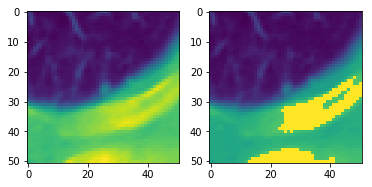

In [14]:
import matplotlib.pyplot as plt
plt.figure(1)
plt.subplot(121)
plt.imshow(nod0[:, :, 25])
plt.subplot(122)
plt.imshow(normalize(nod0[:, :, 25]))
plt.show()

In [15]:
import png
pngWriter = png.Writer(nod0.shape[0], nod0.shape[1], greyscale = True)

In [25]:
for i, cube in tqdm(enumerate(cubes)):
    try:
#         nodule = np.load(os.path.join(CUBE_DIR, nod_id + str("_array.npy")))
        nodule = np.load(os.path.join(CUBE_DIR, cube))
        mid_slice_id = np.int(nodule.shape[2] / 2)
        mid_slice = nodule[:,:, mid_slice_id]
        mid_slice = normalize(mid_slice)
        fname = cube[:6] + ".png"
        f = open(os.path.join(PNG_DIR, fname), "wb")
        pngWriter.write(f, mid_slice)
        f.close()
    except:
        print(str(cube)+" failed")

2609it [00:02, 1265.45it/s]


### Write out RGB versions with 3 channels

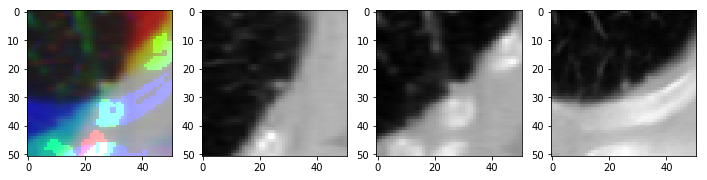

In [201]:
nod0.shape

def three_slice_rgb(x):
    '''
    Take 3 orthogonal slices from a cube and merge in single RGB image
    '''
    
    dim = x.shape
    assert (np.unique(dim)).shape == (1,)
    dim = dim[0]
    
    rgb = np.zeros((dim, dim, 3))
    
    rgb[:, :, 0] = x[np.int(dim / 2),:,:]
    rgb[:, :, 1] = x[:,np.int(dim / 2),:]
    rgb[:, :, 2] = x[:,:,np.int(dim / 2)]

    
    return rgb
    
def three_channel_plot(img, figsize=(12,6), titles=None):
    '''
    Take an RGB version of 3 orthogonal planes, and plot in 4 panels
    '''
    fig, axes = plt.subplots(1, 4, figsize = figsize)
    
    axes[0].imshow(normalize(img))
    axes[1].imshow(img[:, :, 0], cmap = "gray")
    axes[2].imshow(img[:, :, 1], cmap = "gray")
    axes[3].imshow(img[:, :, 2], cmap = "gray")

three_channel_plot(three_slice_rgb((nod0)))

In [205]:
RGB_DIR = os.path.join(DATA_DIR, "nodulesRGB-unsorted")
if not os.path.exists(RGB_DIR):
    os.makedirs(RGB_DIR)

pngWriterRGB = png.Writer(nod0.shape[0], nod0.shape[1], greyscale = False)

In [219]:
for i, nod_id in enumerate(nodule_idx):
    try:
        nodule = np.load(os.path.join(CUBE_DIR, nod_id + str("_array.npy")))
        nodule_rgb = three_slice_rgb(nodule)
        nodule_rgb = normalize(nodule_rgb)
        img = png.from_array(nodule_rgb, mode = "RGB")
        img.save(os.path.join(RGB_DIR, nod_id + str(".png")))
    except:
        print(str(nod_id)+" failed")

005701 failed
006102 failed
007502 failed
016104 failed
018602 failed
019001 failed
036601 failed
045603 failed
051803 failed
055701 failed
058201 failed
060103 failed
070302 failed
078701 failed
083401 failed
084302 failed
086302 failed


Separate for malignant and benign

In [72]:
for i, nod_id in enumerate(malignant_idx):
    try:
        nodule = np.load(os.path.join(CUBE_DIR, "malignant", nod_id + str(".npy")))
        mid_slice_id = np.int(nodule.shape[2] / 2)
        mid_slice = normalize(nodule[:,:, mid_slice_id])
        f = open(os.path.join(PNG_DIR, "malignant", nod_id + str(".png")), "wb")
        pngWriter.write(f, mid_slice)
        f.close()
    except:
        print(str(nod_id)+" failed")

000101 failed
000201 failed
000302 failed
000701 failed
000702 failed
001110 failed
001303 failed
001501 failed
001601 failed
001606 failed
001804 failed
002001 failed
002301 failed
002901 failed
003103 failed
003105 failed
003701 failed
003702 failed
004303 failed
004403 failed
004503 failed
004504 failed
004510 failed
004701 failed
004803 failed
005001 failed
005102 failed
005202 failed
005301 failed
005401 failed
005502 failed
005505 failed
005701 failed
005801 failed
005803 failed
005901 failed
006001 failed
006002 failed
006003 failed
006004 failed
006005 failed
006006 failed
006101 failed
006106 failed
006303 failed
006402 failed
006602 failed
006603 failed
006701 failed
006806 failed
007201 failed
007303 failed
007401 failed
007502 failed
007701 failed
007804 failed
008001 failed
008002 failed
008101 failed
008102 failed
008201 failed
008701 failed
008901 failed
009401 failed
009501 failed
009503 failed
009601 failed
009801 failed
009902 failed
010401 failed
010602 failed
010801

In [135]:
for i, nod_id in enumerate(benign_idx):
    try:
        nodule = np.load(os.path.join(CUBE_DIR, "benign", nod_id + str(".npy")))
        mid_slice_id = np.int(nodule.shape[2] / 2)
        mid_slice = normalize(nodule[:,:, mid_slice_id])
        f = open(os.path.join(PNG_DIR, "benign", nod_id + str(".png")), "wb")
        pngWriter.write(f, mid_slice)
        f.close()
    except:
        print(str(nod_id)+" failed")
        

006102 failed
016104 failed
018602 failed
045603 failed
051803 failed
055701 failed
058201 failed
060103 failed
078701 failed
084302 failed
086302 failed
